### Import Modules

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import pickle
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset, Dataset

### Data Preparation

#### Load and Clean Data

In [ ]:
path = kagglehub.dataset_download("PROPPG-PPG/hourly-weather-surface-brazil-southeast-region")
print("Path to dataset files:", path)

100%|██████████| 1.58G/1.58G [00:38<00:00, 43.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region/versions/9


In [ ]:
print(os.listdir(path))

['south.csv', 'central_west.csv', 'stations.csv', 'make_dataset.py', 'columns_description.csv', 'metrics.py', 'northeast.csv', 'north.csv', 'southeast.csv']


In [ ]:
data_file = path + "/southeast.csv"
df = pd.read_csv(data_file)

In [ ]:
df.head()

,index,Data,Hora,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),...,"VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",region,state,station,station_code,latitude,longitude,height
0,0,2000-05-07,00:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
1,1,2000-05-07,01:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
2,2,2000-05-07,02:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
3,3,2000-05-07,03:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
4,4,2000-05-07,04:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0


In [ ]:
def optimize_dtypes(df):
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')

    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

    return df

df = optimize_dtypes(df)
print(f"Reduced Memory Usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Reduced Memory Usage: 6608.66 MB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15345216 entries, 0 to 15345215
Data columns (total 27 columns):
 #   Column                                                 Dtype  
---  ------                                                 -----  
 0   index                                                  int32  
 1   Data                                                   object 
 2   Hora                                                   object 
 3   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       float32
 4   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  float32
 5   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        float32
 6   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       float32
 7   RADIACAO GLOBAL (Kj/m²)                                int32  
 8   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           float32
 9   TEMPERATURA DO PONTO DE ORVALHO (°C)                   float32
 10  TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)             float32
 

##### Rename Columns

In [ ]:
data_file = path + "/columns_description.csv"
cd = pd.read_csv(data_file)

In [ ]:
display(cd)

,column_index,columns_pt-br,columns_en,abbreviation,description
0,0,data,date,date,date (YYYY-MM-DD)
1,1,hora,hour,hr,hour (HH:00)
2,2,"precipitacao total,horario (mm)",total precipitation (mm),prcp,Amount of precipitation in millimetres (last h...
3,3,pressao atmosferica ao nivel da estacao (mb),atmospheric pressure at station height (mb),stp,Atmospheric pressure at station level (mb)
4,4,pressao atmosferica max. na hora ant. (aut) (mb),atmospheric pressure max. in the previous hour...,smax,Maximum air pressure for the last hour in hPa ...
5,5,pressao atmosferica min. na hora ant. (aut) (mb),atmospheric pressure min. in the previous hour...,smin,Minimum air pressure for the last hour in hPa ...
6,6,radiation (kj/m2),radiation (kj/m2),gbrd,Solar radiation KJ/m2
7,7,temperatura do ar - bulbo seco (°c),air temperature - dry bulb (°c),temp,Air temperature (instant) in celsius degrees
8,8,temperatura do ponto de orvalho (°c),dew point temperature (°c),dewp,Dew point temperature (instant) in celsius deg...
9,9,temperatura maxima na hora ant. (aut) (°c),max. temperature in the previous hour (°c),tmax,Maximum temperature for the last hour in celsi...


In [ ]:
df = df.rename(columns={'Data': 'date',
                        'Hora': 'hour',
                        'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'total precipitation (mm)',
                        'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'atmospheric pressure at station height (mb)',
                        'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'atmospheric pressure max. in the previous hour (mb)',
                        'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'atmospheric pressure min. in the previous hour (mb)',
                        'RADIACAO GLOBAL (Kj/m²)': 'radiation (kj/m2)',
                        'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'air temperature - dry bulb (°c)',
                        'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'dew point temperature (°c)',
                        'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'max. temperature in the previous hour (°c)',
                        'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'min. temperature in the previous hour (°c)',
                        'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)': 'dew temperature max. in the previous hour (°c)',
                        'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)': 'dew temperature min. in the previous hour (°c)',
                        'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'relative humidity max. in the previous hour (%)',
                        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'relative humidity min. in the previous hour (%)',
                        'UMIDADE RELATIVA DO AR, HORARIA (%)': 'air relative humidity (%)',
                        'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'wind direction (° (gr))',
                        'VENTO, RAJADA MAXIMA (m/s)': 'wind rajada maxima (m/s)',
                        'VENTO, VELOCIDADE HORARIA (m/s)': 'wind speed (m/s)',
                        })

In [ ]:
del path
del data_file
del cd
gc.collect()

5

##### Categorical Encoding

In [ ]:
# categorical_features = ['region', 'state', 'station', 'station_code']
# df = pd.get_dummies(df, columns=categorical_features)

In [ ]:
df = df.drop(columns=['region'])
df = df.drop(columns=['state'])
df = df.drop(columns=['station'])
df = df.drop(columns=['station_code'])

##### Handle Missing Values

In [ ]:
df.replace(-9999, np.nan, inplace=True)

In [ ]:
print(df.isnull().sum() / len(df) * 100)

index                                                   0.000000
date                                                    0.000000
hour                                                    0.000000
total precipitation (mm)                                8.631328
atmospheric pressure at station height (mb)             7.262615
atmospheric pressure max. in the previous hour (mb)     7.315283
atmospheric pressure min. in the previous hour (mb)     7.314866
radiation (kj/m2)                                      46.159057
air temperature - dry bulb (°c)                         6.720414
dew point temperature (°c)                              7.928673
max. temperature in the previous hour (°c)              6.767321
min. temperature in the previous hour (°c)              6.766930
dew temperature max. in the previous hour (°c)          7.983192
dew temperature min. in the previous hour (°c)          8.061314
relative humidity max. in the previous hour (%)         7.755342
relative humidity min. in

In [ ]:
'''
drop radiation as almost half entries are missing
'''
df = df.drop(columns=['radiation (kj/m2)'])
df = df.drop(columns=['index'])

In [ ]:
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['hour'])
df.set_index('datetime', inplace=True)

# df.drop(columns=['date', 'hour'], inplace=True)

# interpolate missing values
df.interpolate(method='time', inplace=True)

<ipython-input-15-e18caad40429>:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='time', inplace=True)


In [ ]:
df.dropna(inplace=True)

In [ ]:
print(df.isnull().sum() / len(df) * 100)

date                                                   0.0
hour                                                   0.0
total precipitation (mm)                               0.0
atmospheric pressure at station height (mb)            0.0
atmospheric pressure max. in the previous hour (mb)    0.0
atmospheric pressure min. in the previous hour (mb)    0.0
air temperature - dry bulb (°c)                        0.0
dew point temperature (°c)                             0.0
max. temperature in the previous hour (°c)             0.0
min. temperature in the previous hour (°c)             0.0
dew temperature max. in the previous hour (°c)         0.0
dew temperature min. in the previous hour (°c)         0.0
relative humidity max. in the previous hour (%)        0.0
relative humidity min. in the previous hour (%)        0.0
air relative humidity (%)                              0.0
wind direction (° (gr))                                0.0
wind rajada maxima (m/s)                               0

In [ ]:
display(df)

,date,hour,total precipitation (mm),atmospheric pressure at station height (mb),atmospheric pressure max. in the previous hour (mb),atmospheric pressure min. in the previous hour (mb),air temperature - dry bulb (°c),dew point temperature (°c),max. temperature in the previous hour (°c),min. temperature in the previous hour (°c),...,dew temperature min. in the previous hour (°c),relative humidity max. in the previous hour (%),relative humidity min. in the previous hour (%),air relative humidity (%),wind direction (° (gr)),wind rajada maxima (m/s),wind speed (m/s),latitude,longitude,height
datetime,,,,,,,,,,,,,,,,,,,,,
2000-05-07 12:00:00,2000-05-07,12:00,0.0,1012.500000,1012.500000,1012.000000,22.000000,18.000000,22.000000,20.799999,...,17.799999,87.0,77.0,78.0,30.0,1.4,0.7,-22.799999,-43.683334,33.0
2000-05-07 13:00:00,2000-05-07,13:00,0.0,1013.000000,1013.000000,1012.599976,22.400000,18.000000,22.500000,22.000000,...,17.200001,77.0,74.0,76.0,212.0,2.2,0.5,-22.799999,-43.683334,33.0
2000-05-07 14:00:00,2000-05-07,14:00,0.0,1012.700012,1013.000000,1012.700012,22.600000,17.600000,22.799999,22.400000,...,17.600000,77.0,73.0,73.0,213.0,4.6,2.5,-22.799999,-43.683334,33.0
2000-05-07 15:00:00,2000-05-07,15:00,0.0,1012.200012,1012.700012,1012.200012,22.600000,18.000000,22.799999,22.500000,...,17.200001,75.0,71.0,75.0,223.0,5.8,2.9,-22.799999,-43.683334,33.0
2000-05-07 16:00:00,2000-05-07,16:00,0.0,1012.000000,1012.299988,1012.000000,22.100000,17.400000,22.600000,21.799999,...,17.400000,77.0,74.0,74.0,239.0,8.7,3.7,-22.799999,-43.683334,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-02 01:00:00,2021-02-02,01:00,0.0,929.500000,838.599976,903.500000,25.200001,20.400000,25.400000,20.299999,...,19.799999,61.0,81.0,61.0,220.0,4.0,3.4,-20.909891,-47.114258,845.0
2021-02-02 02:00:00,2021-02-02,02:00,0.0,940.400024,1010.900024,1014.599976,19.000000,18.299999,21.700001,21.100000,...,18.299999,64.0,52.0,70.0,80.0,0.8,2.4,-20.909891,-47.114258,845.0
2021-02-02 03:00:00,2021-02-02,03:00,0.4,867.200012,949.299988,875.200012,22.500000,17.200001,23.700001,19.400000,...,20.500000,90.0,83.0,88.0,69.0,2.6,0.5,-20.909891,-47.114258,845.0


In [ ]:
df.to_csv("data.csv", index=False)

#### Exploratory Data Analysis

##### Visualize distributions of key features

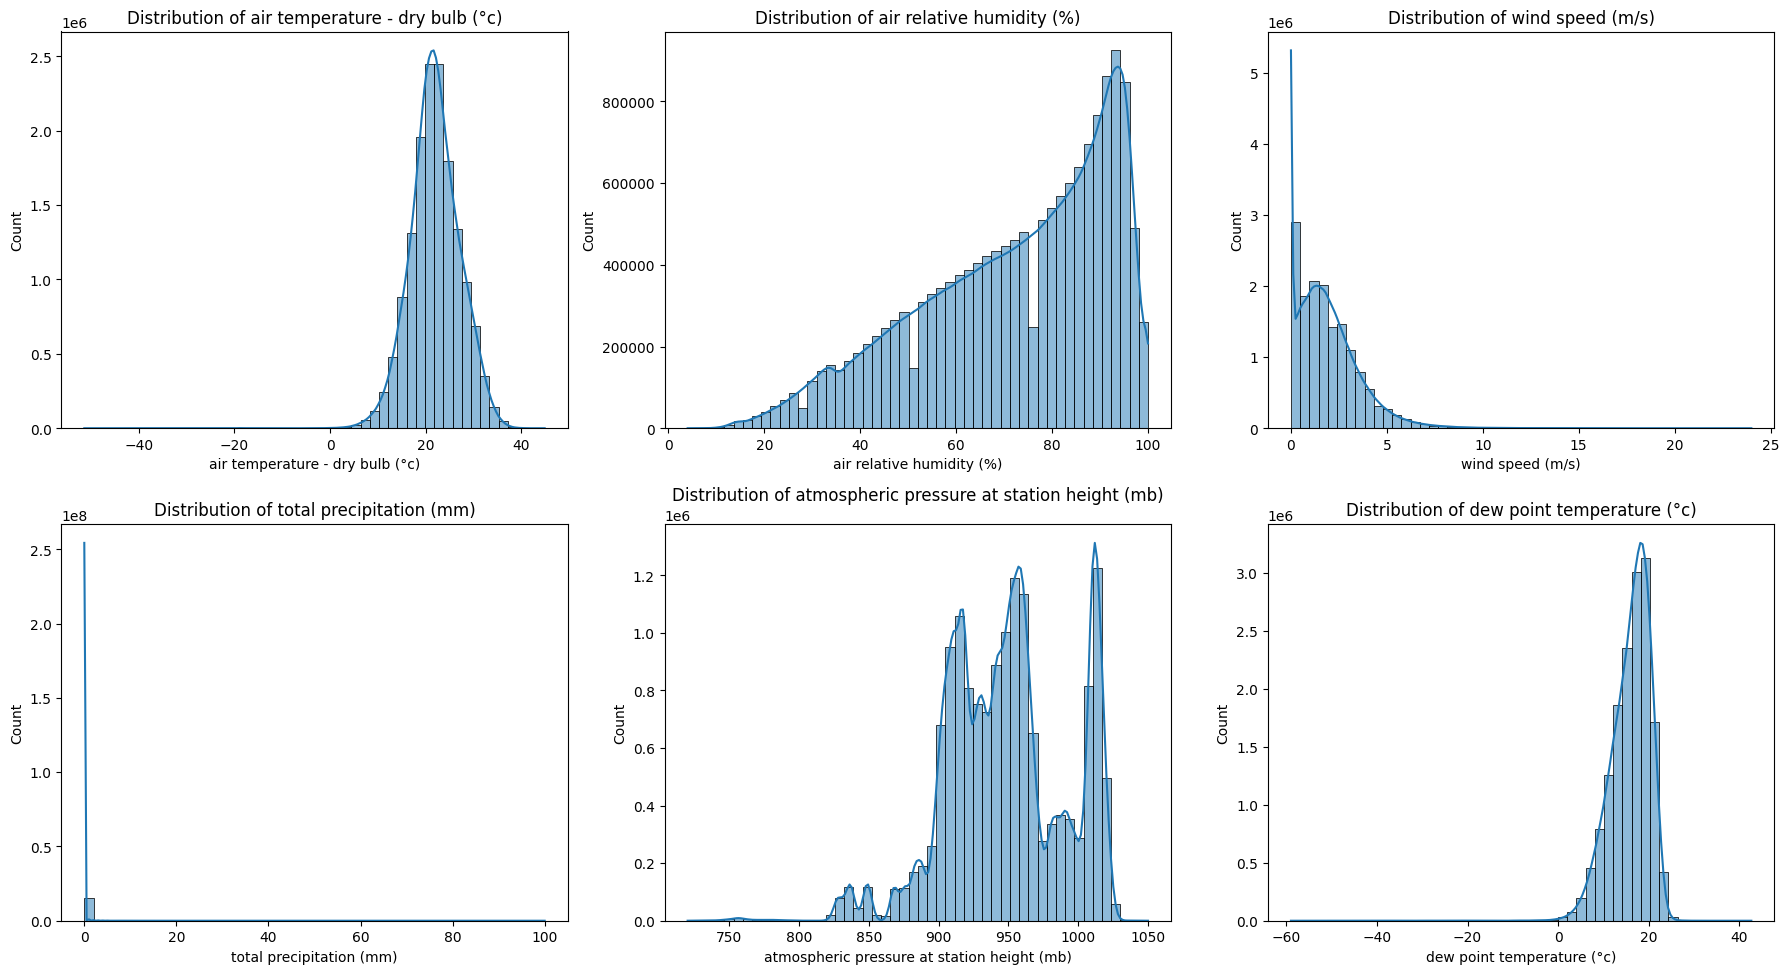

In [ ]:
features = ['air temperature - dry bulb (°c)', 'air relative humidity (%)', 'wind speed (m/s)',
            'total precipitation (mm)', 'atmospheric pressure at station height (mb)', 'dew point temperature (°c)']
plt.figure(figsize=(18, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

##### Time series plots for temperature, humidity, and wind speed


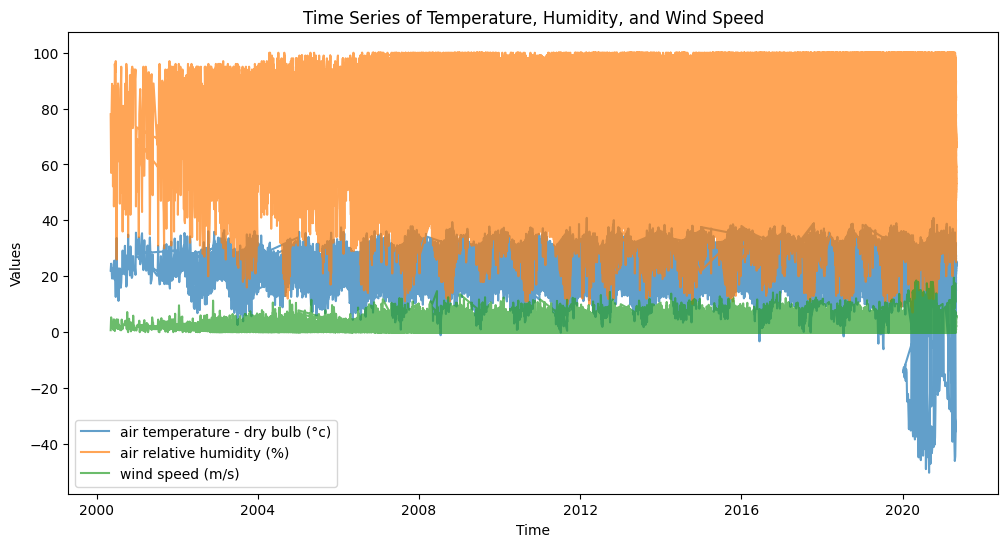

In [ ]:
n = 100
df_sampled = df.iloc[::n, :]

plt.figure(figsize=(12, 6))
for feature in features[:3]:
    plt.plot(df_sampled.index, df_sampled[feature], label=feature, alpha=0.7)

plt.legend()
plt.title("Time Series of Temperature, Humidity, and Wind Speed")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

##### Outliers

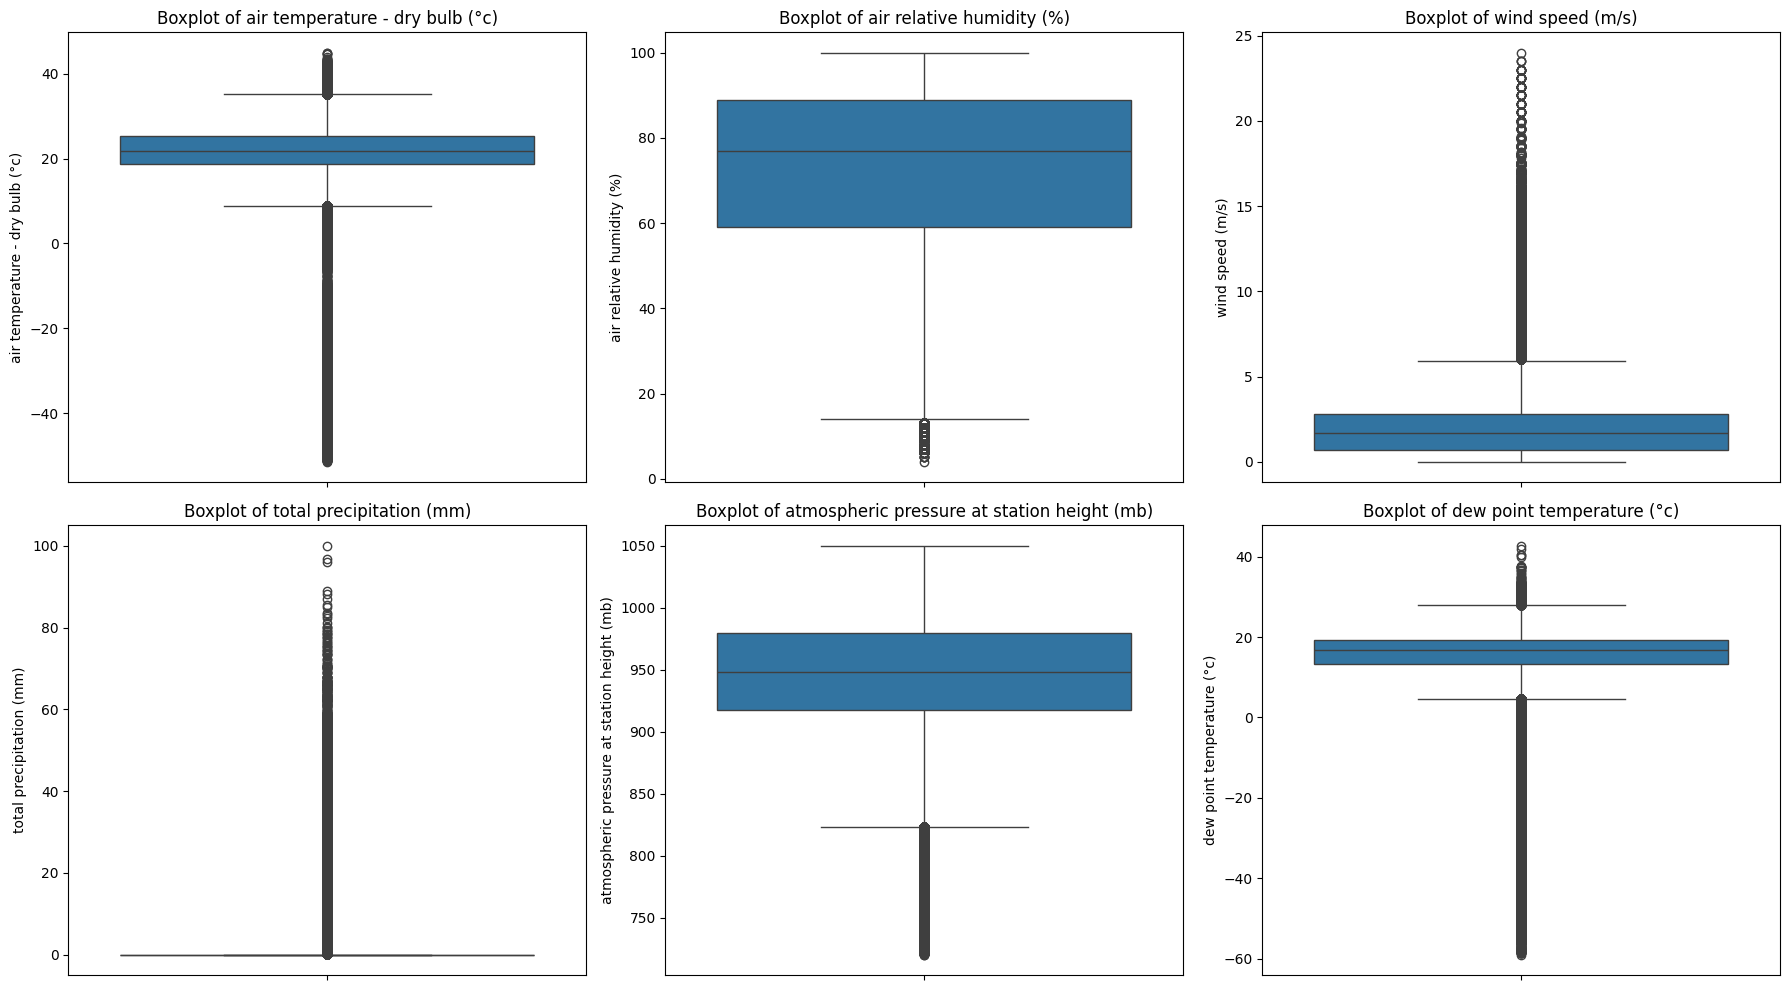

In [ ]:
plt.figure(figsize=(18, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

#### Data Preprocessing

In [ ]:
df = pd.read_csv("data25p.csv")

In [ ]:
display(df)

,date,hour,total precipitation (mm),atmospheric pressure at station height (mb),atmospheric pressure max. in the previous hour (mb),atmospheric pressure min. in the previous hour (mb),air temperature - dry bulb (°c),dew point temperature (°c),max. temperature in the previous hour (°c),min. temperature in the previous hour (°c),...,dew temperature min. in the previous hour (°c),relative humidity max. in the previous hour (%),relative humidity min. in the previous hour (%),air relative humidity (%),wind direction (° (gr)),wind rajada maxima (m/s),wind speed (m/s),latitude,longitude,height
0,2018-10-29,06:00,0.6,1016.1,1016.1,1016.1,17.8,17.1,18.1,17.7,...,16.8,96.0,93.0,96.0,67.0,1.0,0.0,-22.975834,-44.303333,6.0
1,2018-10-29,07:00,0.2,1016.2,1016.2,1016.0,17.8,17.1,17.8,17.6,...,16.9,96.0,95.0,96.0,290.0,1.3,0.0,-22.975834,-44.303333,6.0
2,2018-10-29,08:00,0.0,1016.5,1016.5,1016.2,17.9,17.2,17.9,17.7,...,16.9,96.0,95.0,96.0,239.0,1.5,0.0,-22.975834,-44.303333,6.0
3,2018-10-29,09:00,0.0,1017.1,1017.1,1016.5,18.0,17.2,18.2,17.7,...,17.0,96.0,94.0,95.0,353.0,1.4,0.1,-22.975834,-44.303333,6.0
4,2018-10-29,10:00,0.0,1017.9,1017.9,1017.1,18.5,17.6,18.6,18.0,...,17.1,95.0,94.0,95.0,266.0,1.5,0.1,-22.975834,-44.303333,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3836296,2021-02-02,01:00,0.0,929.5,838.6,903.5,25.2,20.4,25.4,20.3,...,19.8,61.0,81.0,61.0,220.0,4.0,3.4,-20.909891,-47.114258,845.0
3836297,2021-02-02,02:00,0.0,940.4,1010.9,1014.6,19.0,18.3,21.7,21.1,...,18.3,64.0,52.0,70.0,80.0,0.8,2.4,-20.909891,-47.114258,845.0
3836298,2021-02-02,03:00,0.4,867.2,949.3,875.2,22.5,17.2,23.7,19.4,...,20.5,90.0,83.0,88.0,69.0,2.6,0.5,-20.909891,-47.114258,845.0
3836299,2021-02-02,04:00,0.0,1008.8,1010.6,1009.7,24.3,18.3,23.3,22.3,...,19.8,96.0,93.0,90.0,314.0,4.4,0.8,-20.909891,-47.114258,845.0


In [ ]:
df["hour"] = df["hour"].str.extract(r"(\d+)").astype(int)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

df["month"] = pd.to_datetime(df["date"]).dt.month
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

df = df.drop(columns=["date", "hour", "month"])

##### Normalisation

In [ ]:
numeric_columns = df.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [ ]:
df.head()

,total precipitation (mm),atmospheric pressure at station height (mb),atmospheric pressure max. in the previous hour (mb),atmospheric pressure min. in the previous hour (mb),air temperature - dry bulb (°c),dew point temperature (°c),max. temperature in the previous hour (°c),min. temperature in the previous hour (°c),dew temperature max. in the previous hour (°c),dew temperature min. in the previous hour (°c),...,wind direction (° (gr)),wind rajada maxima (m/s),wind speed (m/s),latitude,longitude,height,hour_sin,hour_cos,month_sin,month_cos
0,0.006250,0.946897,0.94656,0.947823,0.733828,0.839030,0.731785,0.740385,0.806383,0.855693,...,0.183844,0.020,0.000000,0.698546,0.88763,0.001365,1.000000,0.500000,0.066987,0.75
1,0.002083,0.947217,0.94688,0.947503,0.733828,0.839030,0.728617,0.739316,0.807447,0.856821,...,0.805014,0.026,0.000000,0.698546,0.88763,0.001365,0.982963,0.370590,0.066987,0.75
2,0.000000,0.948177,0.94784,0.948143,0.734889,0.840132,0.729673,0.740385,0.807447,0.856821,...,0.662953,0.030,0.000000,0.698546,0.88763,0.001365,0.933013,0.250000,0.066987,0.75
3,0.000000,0.950096,0.94976,0.949104,0.735949,0.840132,0.732841,0.740385,0.809574,0.857948,...,0.980501,0.028,0.004167,0.698546,0.88763,0.001365,0.853553,0.146447,0.066987,0.75
4,0.000000,0.952655,0.95232,0.951024,0.741251,0.844542,0.737064,0.743590,0.813830,0.859076,...,0.738162,0.030,0.004167,0.698546,0.88763,0.001365,0.750000,0.066987,0.066987,0.75


In [ ]:
del scaler
del numeric_columns
gc.collect()

21

##### Extract 'normal' data

In [ ]:
def detect_outlier_thresholds(df, column):
    Q1 = df[column].quantile(0.25)  # first quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # third quartile (75th percentile)
    IQR = Q3 - Q1  # interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [ ]:
def label_anomalies(df):
    anomaly_mask = pd.Series(False, index=df.index)

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        low, high = detect_outlier_thresholds(df, col)
        anomaly_mask |= (df[col] < low) | (df[col] > high)

    df["is_anomaly"] = anomaly_mask.astype(int)
    return df

df = label_anomalies(df)

print(f"Original Data Shape: {df.shape}")
print(f"Anomalies Detected: {df['is_anomaly'].sum()}")

Original Data Shape: (3836301, 24)
Anomalies Detected: 580308


In [ ]:
def filter_normal_data(df):
    normal_mask = pd.Series(True, index=df.index)

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        low, high = detect_outlier_thresholds(df, col)
        normal_mask &= (df[col] >= low) & (df[col] <= high)

    return df[normal_mask]

df_normal = filter_normal_data(df)

print(f"Original Data Shape: {df.shape}")
print(f"Filtered Data Shape: {df_normal.shape}")

Original Data Shape: (3836301, 24)
Filtered Data Shape: (3255993, 24)


##### Create sequences for time series forecasting


In [ ]:
# def create_sequences(data, seq_length):
#     sequences, targets = [], []

#     for i in range(len(data) - seq_length):
#         sequences.append(data.iloc[i:i+seq_length].values)
#         targets.append(data.iloc[i+seq_length].values)

#     return np.array(sequences), np.array(targets)

# sequence_length = 12
# X, y = create_sequences(df_normal, sequence_length)

# print(f"Input shape: {X.shape}, Target shape: {y.shape}")

##### Train Test Validation Split (for VAE)

In [ ]:
train_size = int(0.7 * len(df_normal))
val_size = int(0.1 * len(df_normal))

train_data_normal = df_normal.iloc[:train_size]
val_data_normal = df_normal.iloc[train_size:train_size+val_size]
df_test = df.drop(columns=["is_anomaly"])
true_labels = df["is_anomaly"].values

### VAE for anomaly detection

#### Training (normal weather patterns)

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # encoder
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        # decoder
        self.fc3 = nn.Linear(latent_dim, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, input_dim)

    def encode(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = torch.relu(self.fc3(z))
        z = torch.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        seq = self.data.iloc[idx : idx + self.seq_length].values.astype(np.float32)
        seq = torch.tensor(seq, dtype=torch.float32)
        return seq

def create_dataloader(data, seq_length, batch_size=64, shuffle=False):
    dataset = TimeSeriesDataset(data, seq_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)

In [ ]:
sequence_length = 24  # past 24 hours
batch_size = 32

train_loader = create_dataloader(train_data_normal, sequence_length, batch_size)
val_loader = create_dataloader(val_data_normal, sequence_length, batch_size)
test_loader = create_dataloader(test_data, sequence_length, batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(input_dim=train_data_normal.shape[1], latent_dim=10).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

def train_vae(model, train_loader, val_loader, epochs=3):
    model.train()
    model.to(device)
    for epoch in range(epochs):
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(batch)

            # loss (reconstruction + kl divergence)
            recon_loss = loss_fn(recon, batch)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                recon, mu, logvar = model(batch)
                recon_loss = loss_fn(recon, batch)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + kl_loss
                val_loss += loss.item()

        print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

train_vae(vae, train_loader, val_loader, epochs=3)

Epoch 1: Train Loss: 0.0298, Val Loss: 0.0338
Epoch 2: Train Loss: 0.0328, Val Loss: 0.0340
Epoch 3: Train Loss: 0.0328, Val Loss: 0.0340


#### Testing anomaly detection

In [ ]:
vae.eval()
all_recon_errors = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        recon, _, _ = vae(batch)
        recon_error = torch.mean((batch - recon) ** 2, dim=1).cpu().numpy()
        all_recon_errors.extend(recon_error)

In [ ]:
# all_recon_errors = np.mean(all_recon_errors, axis=1)
# true_labels = np.array(true_labels).flatten()

# true_labels = (true_labels >= 0).astype(int)

window_size = 48
smoothed_errors = np.convolve(all_recon_errors, np.ones(window_size) / window_size, mode="valid")

threshold = np.percentile(smoothed_errors, 10)
anomalies = (smoothed_errors > threshold).astype(int)

true_labels = true_labels[:len(smoothed_errors)]

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, anomalies, average="binary")

print(f"Anomaly Detection Results:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Anomaly Detection Results:
Precision: 0.1397, Recall: 0.9037, F1-score: 0.2420


### GRU for time series forecasting

In [ ]:
N_HOURS = 24  # past hours used for prediction
M_HOURS = 6   # future hours to predict
FEATURES = 23
HIDDEN_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 5
TEACHER_FORCING_RATIO = 1.0
decay_rate = 0.95

In [ ]:
class WeatherDataset(Dataset):
    def __init__(self, data, seq_len=N_HOURS, pred_len=M_HOURS):
        self.data = np.array(data, dtype=np.float32)
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len

    def __getitem__(self, idx):
        past_seq = self.data[idx : idx + self.seq_len]
        future_seq = self.data[idx + self.seq_len : idx + self.seq_len + self.pred_len]
        return torch.tensor(past_seq, dtype=torch.float32), torch.tensor(future_seq, dtype=torch.float32)

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, future_steps=0, teacher_forcing=False, target_future=None):
        batch_size = x.size(0)
        h = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        output, h = self.gru(x, h)
        pred = self.fc(output[:, -1, :])

        preds = [pred]
        for i in range(1, future_steps):
            if teacher_forcing and target_future is not None:
                inp = target_future[:, i-1, :].unsqueeze(1)
            else:
                inp = preds[-1].unsqueeze(1)
            out, h = self.gru(inp, h)
            pred = self.fc(out[:, -1, :])
            preds.append(pred)

        return torch.stack(preds, dim=1)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    global TEACHER_FORCING_RATIO
    train_losses, val_losses, test_losses = [], [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for past_seq, future_seq in train_loader:
            past_seq, future_seq = past_seq.to(device), future_seq.to(device)
            optimizer.zero_grad()

            teacher_forcing = np.random.rand() < TEACHER_FORCING_RATIO
            predictions = model(past_seq, future_steps=M_HOURS, teacher_forcing=teacher_forcing, target_future=future_seq)

            loss = criterion(predictions, future_seq)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        TEACHER_FORCING_RATIO *= decay_rate

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for past_seq, future_seq in val_loader:
                past_seq, future_seq = past_seq.to(device), future_seq.to(device)
                predictions = model(past_seq, future_steps=M_HOURS, teacher_forcing=False)
                loss = criterion(predictions, future_seq)
                val_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.legend()
    plt.title("Loss Curves")
    plt.show()

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_actuals = [], []
    with torch.no_grad():
        for past_seq, future_seq in test_loader:
            past_seq, future_seq = past_seq.to(device), future_seq.to(device)
            predictions = model(past_seq, future_steps=M_HOURS, teacher_forcing=False)
            loss = criterion(predictions, future_seq)
            total_loss += loss.item()
            all_preds.append(predictions.cpu().numpy())
            all_actuals.append(future_seq.cpu().numpy())

    return total_loss / len(test_loader), np.concatenate(all_preds), np.concatenate(all_actuals)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_size = int(0.7 * len(df))
val_size = int(0.1 * len(df))

train_data = df.iloc[:train_size].to_numpy()
val_data = df.iloc[train_size:train_size+val_size].to_numpy()
test_data = df.iloc[train_size+val_size:].to_numpy()

train_dataset = WeatherDataset(train_data)
val_dataset = WeatherDataset(val_data)
test_dataset = WeatherDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = GRU(FEATURES, HIDDEN_SIZE, FEATURES).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/5, Train Loss: 0.0033, Val Loss: 0.0038
Epoch 2/5, Train Loss: 0.0031, Val Loss: 0.0043
Epoch 3/5, Train Loss: 0.0031, Val Loss: 0.0040
Epoch 4/5, Train Loss: 0.0031, Val Loss: 0.0036
Epoch 5/5, Train Loss: 0.0032, Val Loss: 0.0037


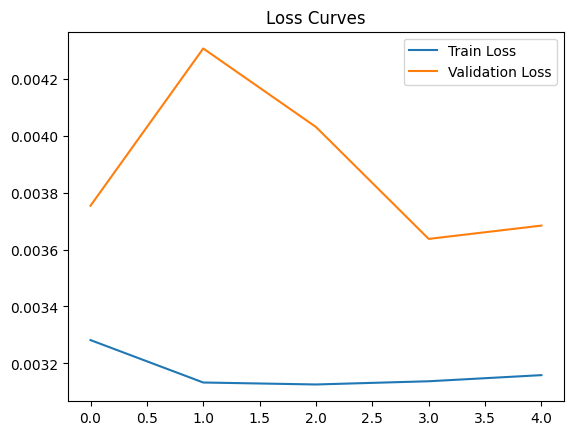

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS)

In [ ]:
test_loss, preds, actuals = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0066


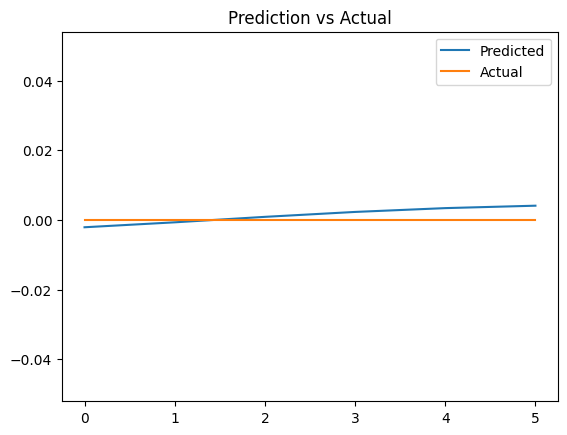

In [ ]:
plt.plot(preds[0, :, 0], label="Predicted")
plt.plot(actuals[0, :, 0], label="Actual")
plt.legend()
plt.title("Prediction vs Actual")

y_min = min(preds[0, :, 0].min(), actuals[0, :, 0].min()) - 0.05
y_max = max(preds[0, :, 0].max(), actuals[0, :, 0].max()) + 0.05
plt.ylim(y_min, y_max)

plt.show()